In [1]:
from dataclasses import dataclass
from pathlib import Path
from typing import TypedDict
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
class Time(TypedDict):
    """picoseconds"""

    fastest: int
    mean: int
    median: int
    slowest: int

class Result(TypedDict):
    time: Time

class Benchmark(TypedDict):
    path: list[str]
    result: Result

class Report(TypedDict):
    benchmarks: list[Benchmark]

In [3]:
@dataclass
class Record:
    binary: str
    operation: str
    implementation: str
    len: str
    fastest: int
    mean: int
    median: int
    slowest: int

report: Report = json.loads(Path("target/bench.json").read_text())
"""
rm target/bench.json; cargo bench --bench against-nonempty -- --file target/bench.json --format jsonflat --sample-count 500000
"""

records = []
for benchmark in report["benchmarks"]:
    records.append(Record(
        binary=benchmark["path"][0],
        operation=benchmark["path"][1],
        implementation=benchmark["path"][2].replace("NonEmpty<alloc::vec::Vec<u8>>", "crate:nunny").replace("NonEmpty<u8>", "crate:nonempty"),
        len=benchmark["path"][3],

        fastest=benchmark["result"]["time"]["fastest"],
        mean=benchmark["result"]["time"]["mean"],
        median=benchmark["result"]["time"]["median"],
        slowest=benchmark["result"]["time"]["slowest"],
    ))

In [4]:
df = pd.DataFrame(records)

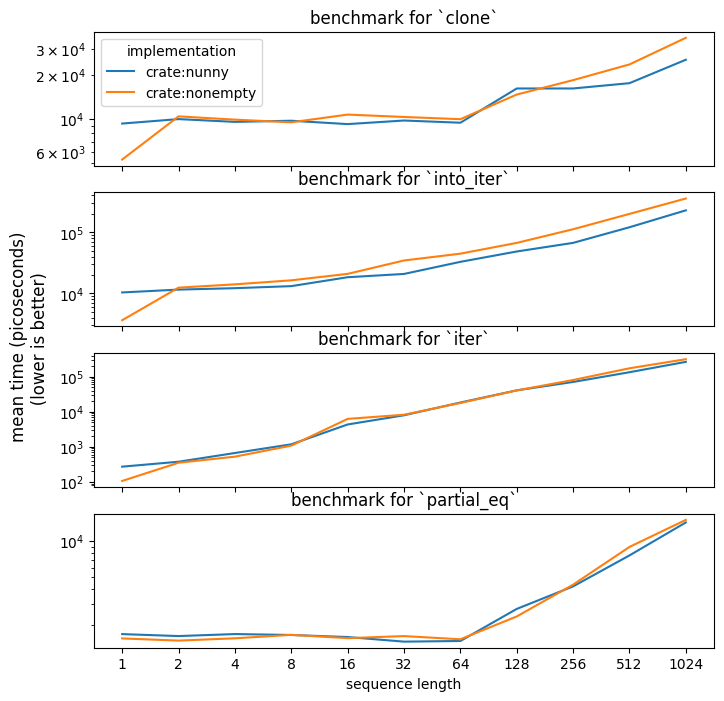

In [5]:
operations = df["operation"].unique()

fig, axs = plt.subplots(nrows=len(operations), sharex=True)
for ix, op in enumerate(operations):
    ax = sns.lineplot(df[df["operation"] == op], x="len", y="mean", hue="implementation", ax=axs[ix])
    ax.set_yscale("log")
    ax.set_xlabel("sequence length")
    ax.set(ylabel=None)
    ax.set_title(f"benchmark for `{op}`")
    if ix != 0:
        ax.get_legend().remove()
fig.supylabel("mean time (picoseconds)\n       (lower is better)")
fig.set_size_inches(8, 8)

